# Local level model: inference and forecasts

Basic state-space model with measurement error and an AR(1) latent process.

$$y_t = \gamma + \eta z_t + \epsilon_t, \quad \epsilon_t \sim N_{0,\sigma^2}, \quad t=1,\dots,\tau$$
$$z_t = \rho z_{t-1} + \nu_t\quad \nu_t \sim N_{0,1}, \quad t=2,\dots,\tau$$
$$z_1 \sim N_{0, (1+\rho^2)^{-1/2}} $$

See the graphs below and code for information about the priors and inference, which is a structured (full-rank) VI procedure.

## Executive summary

For some reason, a 'worse' elbo approximation performs much better. I am still trying to work out why. It could be a random chance/overfit, or it could be something a bit more general.

In the example given in this notebook, the 'good' VI approximation would be unusable in practice, whereas the 'bad' one is actually quite reasonable. What gives?

## Preliminaries

In [1]:
from ptvi import plot_dens, LocalLevelModel
import torch
import pandas as pd
pd.set_option('precision', 2)
seed = 1234

Define the true parameter values and generate data.

In [2]:
γ0, η0, σ0, ρ0 = 0., 2., 1.5, 0.92

In [3]:
torch.manual_seed(seed)
model = LocalLevelModel(τ=100)
y, z = model.simulate(γ=γ0, η=η0, σ=σ0, ρ=ρ0)

## Approximate inference (analytic entropy term)

Our inference procedure is quick, but frankly not super great.

We will do inference twice, with two different elbo estimates. Here we do ADVI, so our elbo is estimated with an analytic entropy term, as

$$ \hat{\mathcal{L}} = \frac{1}{M} \sum_{i=1}^M 
    p(y, \zeta^{(i)}) - 
    \mathbb{E}_{q_{u,L}} \left[ q_{u,L}(\zeta^{(i)}) 
   \right]
$$
where $\zeta^{(i)}\sim q_{u,L}$ via the reparameterization trick. For convenience, we choose $M=1$.

In [4]:
fit = model.training_loop(y, max_iters=2**20)

Local level model with τ=100:
    - analytic entropy;
    - 1 simulation draw;
    - Exponential stopping heuristic (N=50, M=50, α=0.05)

RMSprop optimizer with param groups:
    group 0. lr=0.01, momentum=0, alpha=0.99, eps=1e-08, centered=False, weight_decay=0

Displayed loss is smoothed with λ=0.1
       0. smoothed elbo_hat =  -71.19
       1. smoothed elbo_hat =-5182.25
       2. smoothed elbo_hat =-4498.83
       4. smoothed elbo_hat =-3672.49
       8. smoothed elbo_hat =-2370.87
      16. smoothed elbo_hat =  254.47
      32. smoothed elbo_hat = -439.94
      64. smoothed elbo_hat =69123.70
     128. smoothed elbo_hat =-15313.49
     256. smoothed elbo_hat = -902.04
     512. smoothed elbo_hat =  835.26
    1024. smoothed elbo_hat =  363.09
    2048. smoothed elbo_hat =   12.17
    4096. smoothed elbo_hat =   26.09
    8192. smoothed elbo_hat =   21.43
Early stopping criterion satisfied.
   11450. smoothed elbo_hat =   14.30
Completed 11451 iterations in 14.8s @ 726.51 i/s.


In [5]:
fit.summary()

,mean,sd
γ,0.05,0.09
η,4.39,0.38
σ,0.60,0.13
ρ,0.69,0.02


Note the model's overconfidence about the latent state. You can barely even see the standard deviation band around the blue estimated state.

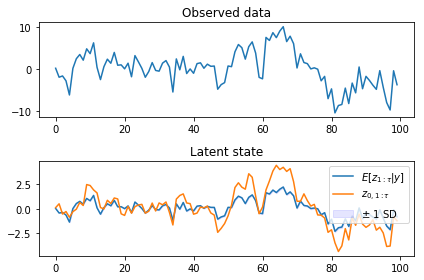

In [6]:
fit.plot_latent(true_z=z.numpy(), include_data=True)

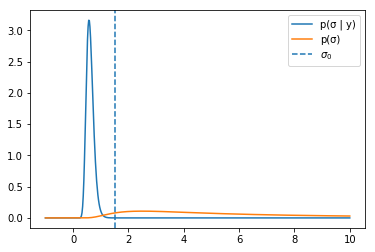

In [7]:
plot_dens({'p(σ | y)': fit.σ_marg_post, 'p(σ)': model.σ_prior, '$σ_0$': σ0}, -1, 10)

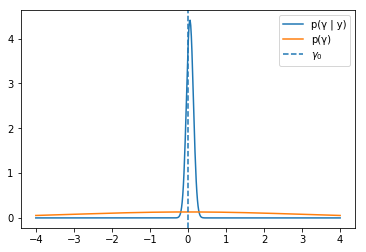

In [8]:
plot_dens({'p(γ | y)': fit.γ_marg_post, 'p(γ)': model.γ_prior, '$γ_0$': γ0}, -4, 4)

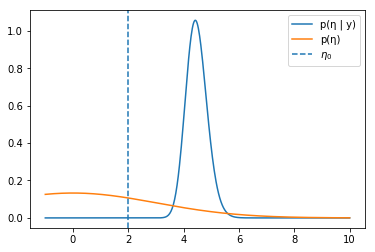

In [9]:
plot_dens({'p(η | y)': fit.η_marg_post, 'p(η)': model.η_prior, '$η_0$': η0}, -1, 10)

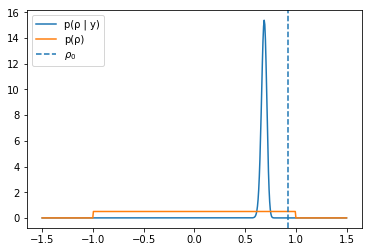

In [10]:
plot_dens({'p(ρ | y)': fit.ρ_marg_post, 'p(ρ)': model.ρ_prior, '$ρ_0$': ρ0}, -1.5, 1.5)

### Forecasts

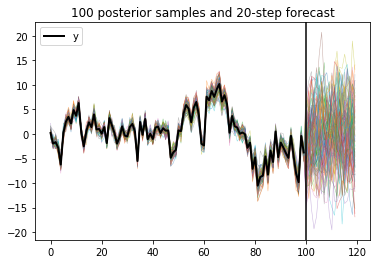

In [11]:
fit.plot_sampled_paths(N=100, true_y=y, fc_steps=20)

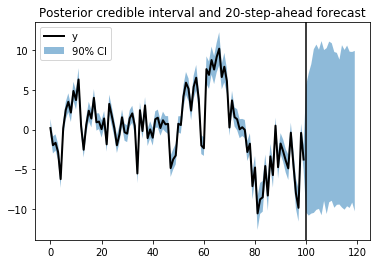

In [12]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## Approximate inference (stochastic entropy term)

Here, our elbo is estimated by simulating the entropy term, as

$$ \hat{\mathcal{L}} = \frac{1}{M} \sum_{i=1}^M \left[
    p(y, \zeta^{(i)}) - q_{u,L}(\zeta^{(i)}) 
   \right]
$$
where $\zeta^{(i)}\sim q_{u,L}$ via the reparameterization trick. For convenience, we choose $M=1$.

**LOOK AT HOW MUCH BETTER THE APPROXIMATION -- AND FORECASTS -- ARE!**

In [13]:
torch.manual_seed(seed)
model = LocalLevelModel(τ=100, stoch_entropy=True)

In [14]:
fit = model.training_loop(y, max_iters=2**20)

Local level model with τ=100:
    - stochastic entropy;
    - 1 simulation draw;
    - Exponential stopping heuristic (N=50, M=50, α=0.05)

RMSprop optimizer with param groups:
    group 0. lr=0.01, momentum=0, alpha=0.99, eps=1e-08, centered=False, weight_decay=0

Displayed loss is smoothed with λ=0.1
       0. smoothed elbo_hat =-1028.70
       1. smoothed elbo_hat =   76.23
       2. smoothed elbo_hat = -202.31
       4. smoothed elbo_hat =  -39.59
       8. smoothed elbo_hat = -689.46
      16. smoothed elbo_hat = 1046.34
      32. smoothed elbo_hat =  125.22
      64. smoothed elbo_hat = -324.03
     128. smoothed elbo_hat = 4998.47
     256. smoothed elbo_hat =  548.70
     512. smoothed elbo_hat =  471.34
    1024. smoothed elbo_hat =  384.93
    2048. smoothed elbo_hat =  -11.47
    4096. smoothed elbo_hat =  -14.98
    8192. smoothed elbo_hat =  -15.67
Early stopping criterion satisfied.
   15600. smoothed elbo_hat =  -16.01
Completed 15601 iterations in 33.5s @ 452.30 i/s.


In [15]:
fit.summary()

,mean,sd
γ,0.13,0.64
η,1.68,0.26
σ,2.30,0.35
ρ,0.87,0.06


The model is now less overconfident about the latent state!

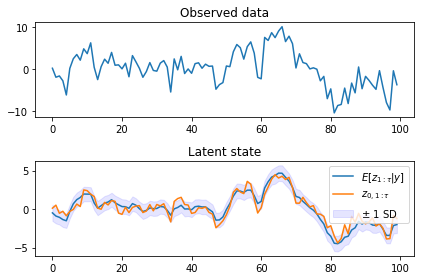

In [16]:
fit.plot_latent(true_z=z.numpy(), include_data=True)

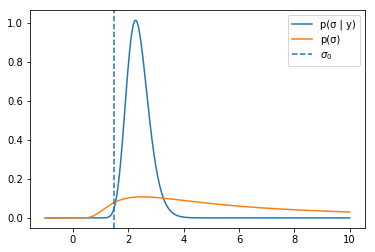

In [17]:
plot_dens({'p(σ | y)': fit.σ_marg_post, 'p(σ)': model.σ_prior, '$σ_0$': σ0}, -1, 10)

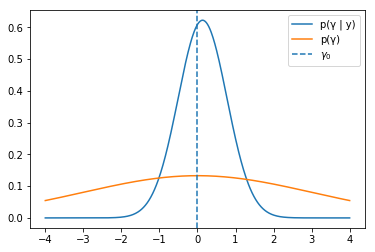

In [18]:
plot_dens({'p(γ | y)': fit.γ_marg_post, 'p(γ)': model.γ_prior, '$γ_0$': γ0}, -4, 4)

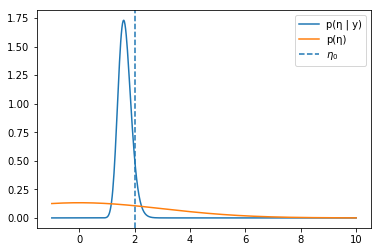

In [19]:
plot_dens({'p(η | y)': fit.η_marg_post, 'p(η)': model.η_prior, '$η_0$': η0}, -1, 10)

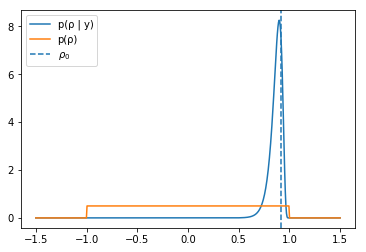

In [20]:
plot_dens({'p(ρ | y)': fit.ρ_marg_post, 'p(ρ)': model.ρ_prior, '$ρ_0$': ρ0}, -1.5, 1.5)

### Forecasts

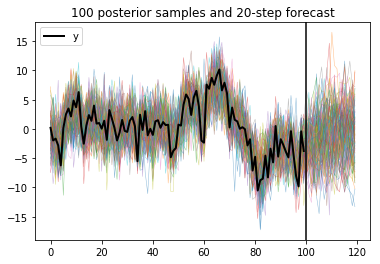

In [21]:
fit.plot_sampled_paths(N=100, true_y=y, fc_steps=20)

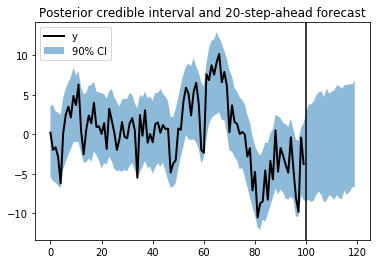

In [22]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)